In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import os
import networkx as nx

In [2]:
#Read discussion network data from a csv file
dnet_df = pd.read_csv('discussion_network_with_affiliations.csv')
#Display the first 5 rows of the dataframe
dnet_df.head()

,consumer,contributor,consumption,contributor_affiliation,consumer_affiliation
0,mitsudome-r,maxime-clem,1,tier4,tier4
1,mitsudome-r,xczhanjun,1,baidu usa,tier4
2,mitsudome-r,xmfcx,7,leodrive,tier4
3,mitsudome-r,meliketanrikulu,1,leodrive,tier4
4,mitsudome-r,kminoda,1,tier4,tier4


In [3]:
dnet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   consumer                 1087 non-null   object
 1   contributor              1087 non-null   object
 2   consumption              1087 non-null   int64 
 3   contributor_affiliation  981 non-null    object
 4   consumer_affiliation     707 non-null    object
dtypes: int64(1), object(4)
memory usage: 42.6+ KB


In [4]:
#Aggregate the data by contributor_affiliation and consumer_affiliation, sum teh values of consumption, keep the contributor_affiliation and consumer_affiliation columns
dnet_grouped = dnet_df.groupby(['contributor_affiliation', 'consumer_affiliation'])['consumption'].sum().reset_index()
#Display the first 5 rows of the dataframe
dnet_grouped.head()

,contributor_affiliation,consumer_affiliation,consumption
0,@SUBU-AISET,Indie Hacker (formerly Databricks),1
1,@nap-it,wg-leads,1
2,@rst-tu-dortmund,tier4,1
3,@uber,tier4,1
4,Autonomous Systems,Nagoya University,1


In [5]:
#describe the dataframe
dnet_grouped.describe()

,consumption
count,220.000000
mean,4.136364
std,13.818773
min,1.000000
25%,1.000000
50%,1.000000
75%,2.250000
max,161.000000


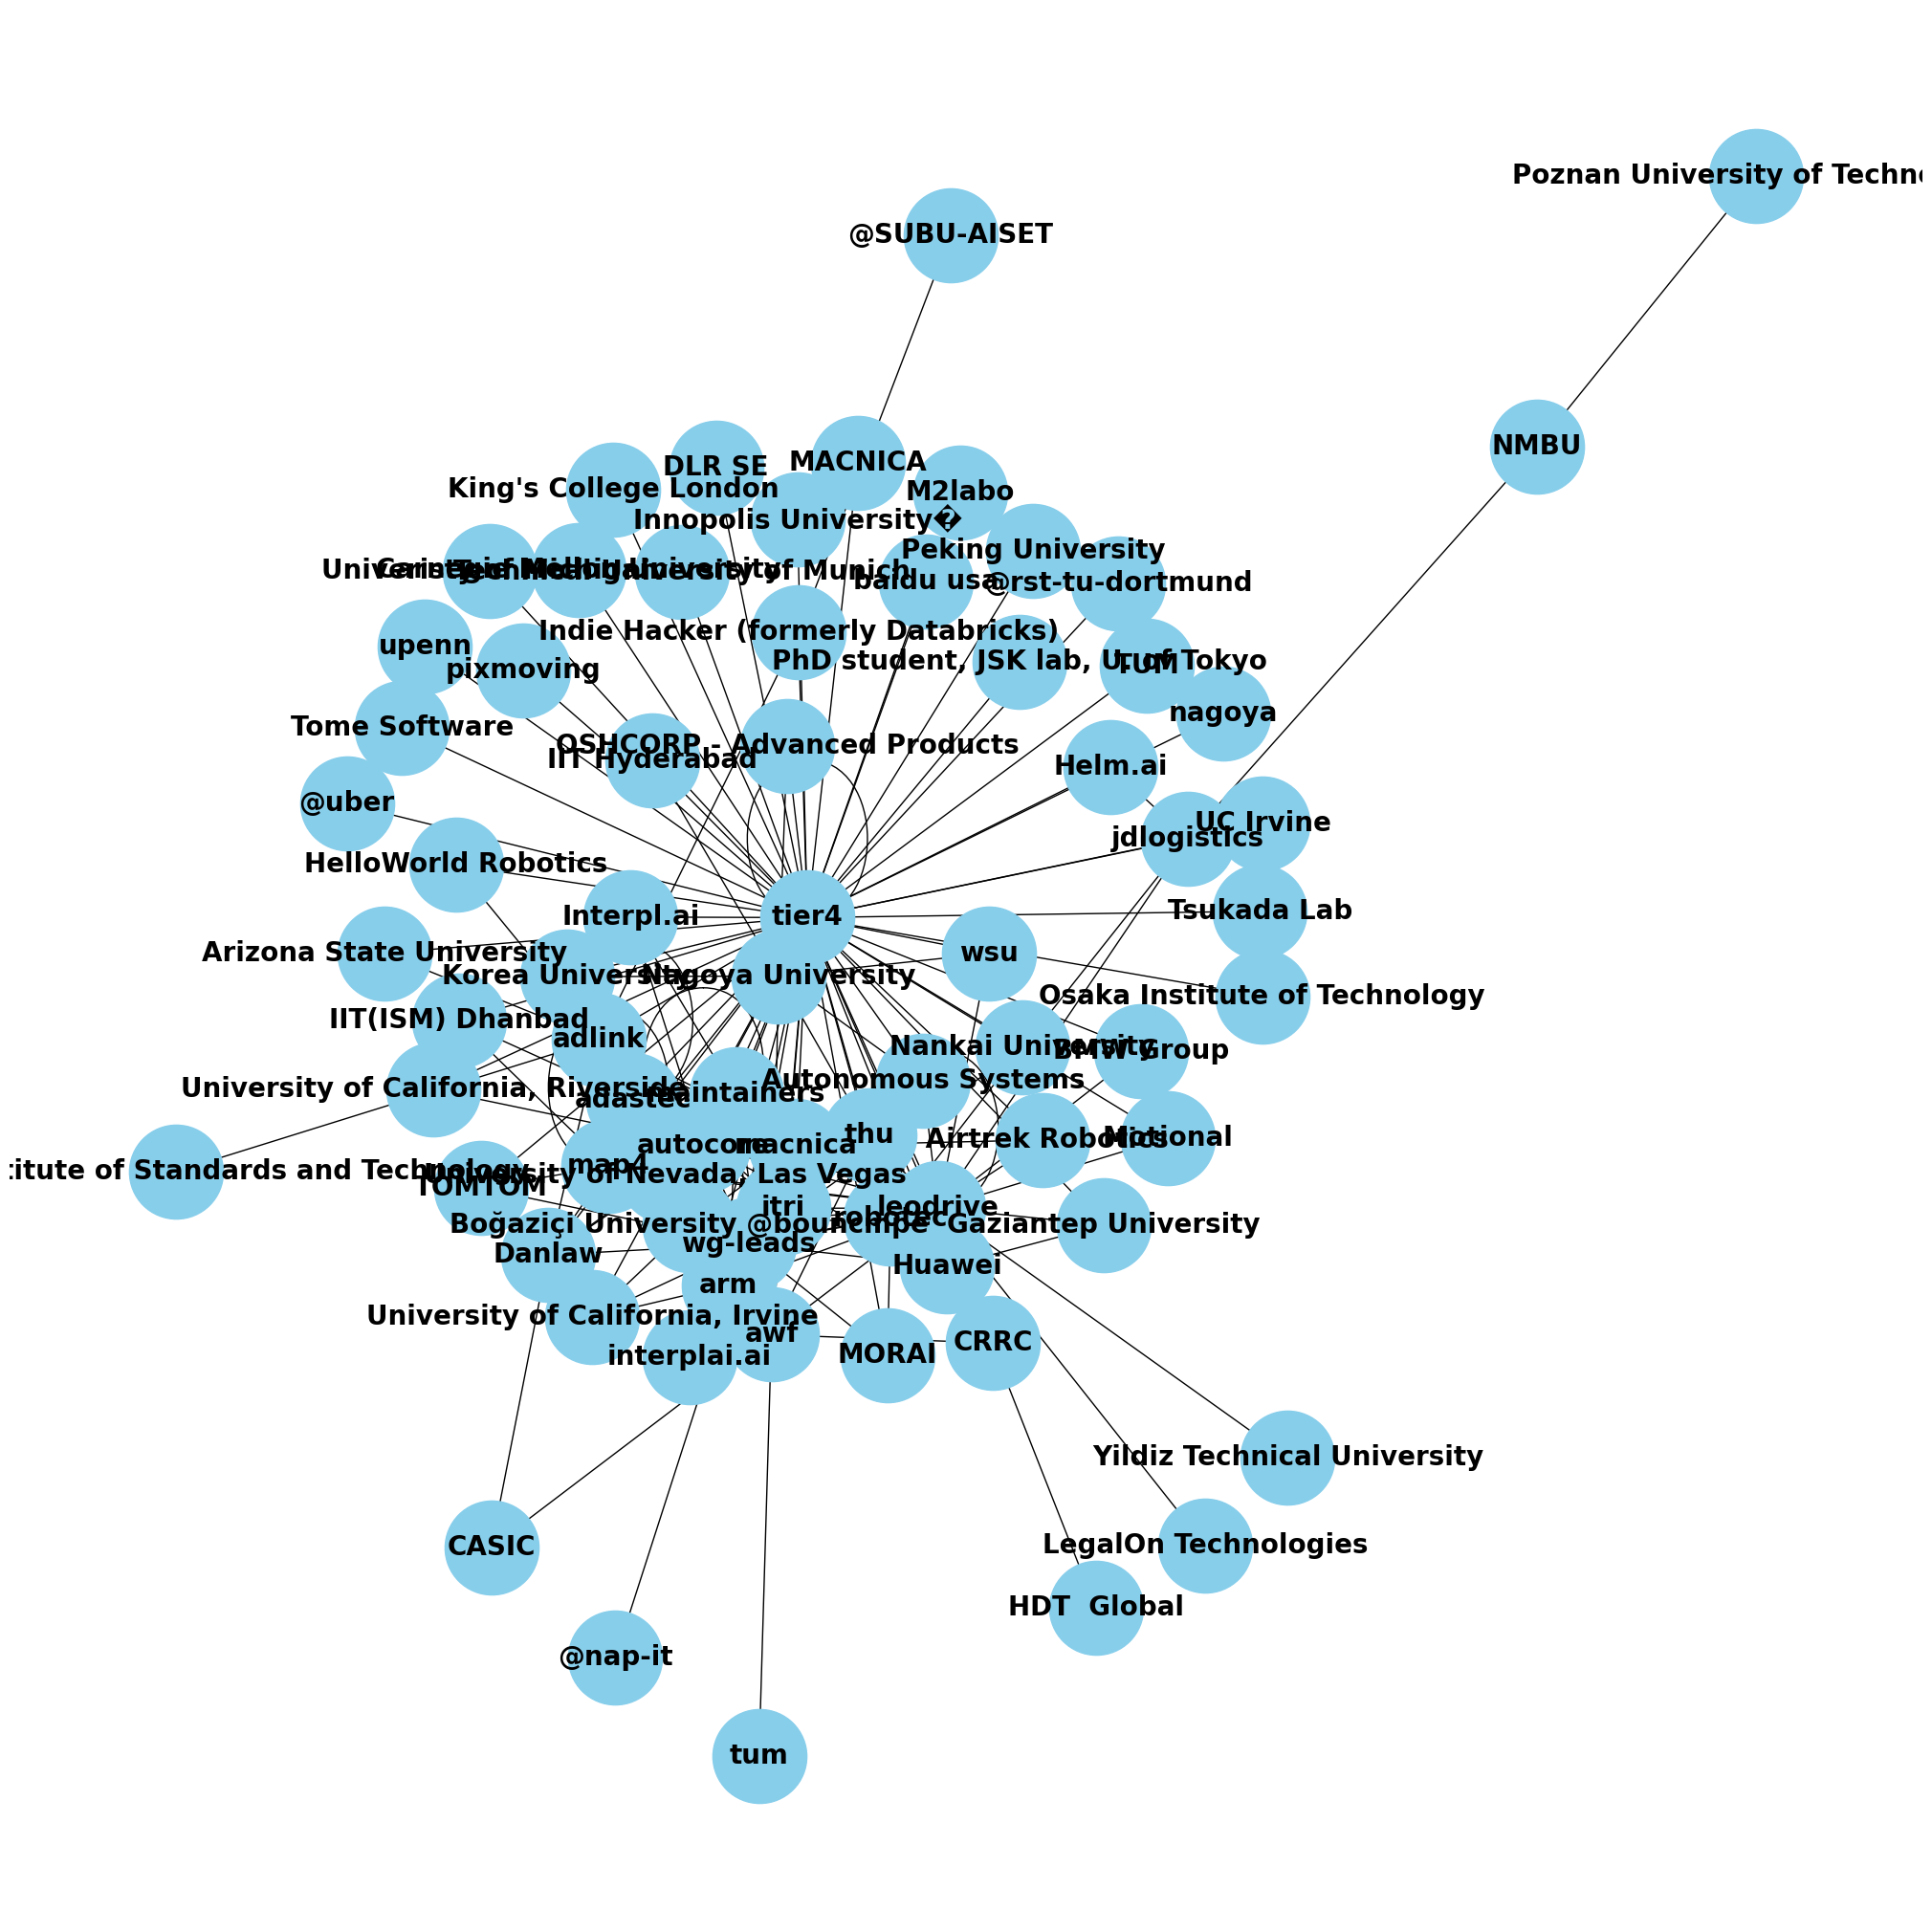

In [6]:
#Draw a network among the affiliations based on the consumption of the discussions
G = nx.from_pandas_edgelist(dnet_grouped, 'contributor_affiliation', 'consumer_affiliation', 'consumption')
plt.figure(figsize=(20, 20))
nx.draw(G, with_labels=True, node_size=5000, node_color='skyblue', font_size=20, font_weight='bold')
plt.show()

In [7]:
# #Right now, the network is assymetric, i.e., we have separate records for consumption from a to b and from b to a. We need to make it symmetric
# #Create a copy of the dataframe
# dnet_grouped_copy = dnet_grouped.copy()
# #Rename the columns
# dnet_grouped_copy.columns = ['consumer_affiliation', 'contributor_affiliation', 'consumption']
# #Append the two dataframes
# dnet_grouped_symmetric = dnet_grouped.append(dnet_grouped_copy)
# #Group the data by contributor_affiliation and consumer_affiliation, sum the values of consumption
# dnet_grouped_symmetric = dnet_grouped_symmetric.groupby(['contributor_affiliation', 'consumer_affiliation'])['consumption'].sum().reset_index()
# #Display the first 5 rows of the dataframe

In [8]:
!pip install pyvis

In [9]:
# Sort the DataFrame based on the "consumption" column from highest to lowest values
dnet_grouped_sorted = dnet_grouped.sort_values(by='consumption', ascending=False)

# Display the sorted DataFrame
print(dnet_grouped_sorted)

    contributor_affiliation consumer_affiliation  consumption
202                   tier4                tier4          161
196                   tier4             leodrive          109
115                leodrive                tier4           46
190                   tier4             autocore           28
110                leodrive             leodrive           27
..                      ...                  ...          ...
85                      awf             wg-leads            1
86                baidu usa                tier4            1
87             interplai.ai                  arm            1
88             interplai.ai                 itri            1
219                     wsu                tier4            1

[220 rows x 3 columns]


In [10]:
import pandas as pd
from pyvis.network import Network

# Read discussion network data from a csv file
dnet_df = pd.read_csv('discussion_network_with_affiliations.csv')

# Aggregate the data by contributor_affiliation and consumer_affiliation, sum the values of consumption
dnet_grouped = dnet_df.groupby(['contributor_affiliation', 'consumer_affiliation'])['consumption'].sum().reset_index()

# Sort the DataFrame by consumption (highest to lowest)
dnet_grouped_sorted = dnet_grouped.sort_values(by='consumption', ascending=False)

# Create a pyvis network with a white background
net = Network(height="750px", width="100%", bgcolor="white", font_color="black", directed=True)

# Create an empty dictionary to store added nodes
added_nodes = {}

# Define the minimum weight threshold for displaying edges
min_weight_threshold = 3

# Create a dictionary to store the count of rows for each pair of interchangeable affiliations
interchangeable_counts = {}

# Count the occurrences of each pair of interchangeable affiliations
for _, row in dnet_grouped.iterrows():
    contributor_affiliation = row['contributor_affiliation']
    consumer_affiliation = row['consumer_affiliation']
    if contributor_affiliation > consumer_affiliation:
        pair = (consumer_affiliation, contributor_affiliation)
    else:
        pair = (contributor_affiliation, consumer_affiliation)
    interchangeable_counts[pair] = interchangeable_counts.get(pair, 0) + 1

# Add nodes for each unique affiliation (handling potential missing values)
for affiliation in pd.concat([dnet_grouped_sorted['contributor_affiliation'], dnet_grouped_sorted['consumer_affiliation']]).unique():
    if not pd.isna(affiliation):
        net.add_node(affiliation, label=affiliation, size=20, color='lightblue')
        added_nodes[affiliation] = True

# Add edges to the network with the aggregated consumption values and adjusted width
for index, row in dnet_grouped_sorted.iterrows():
    contributor_affiliation = row['contributor_affiliation']
    consumer_affiliation = row['consumer_affiliation']
    consumption = row['consumption']

    # Add edge only if contributor and consumer affiliations are not NaN and weight meets threshold
    if not pd.isna(consumer_affiliation) and not pd.isna(contributor_affiliation) and consumption >= min_weight_threshold:
        # Ensure we add edges in both directions for interchangeable affiliations
        edge_key = (contributor_affiliation, consumer_affiliation)
        if interchangeable_counts.get(edge_key, 0) > 1:
            # Add edge between affiliations in both directions if not added already
            if edge_key not in added_nodes:
                net.add_edge(contributor_affiliation, consumer_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[edge_key] = True
            if (consumer_affiliation, contributor_affiliation) not in added_nodes:
                net.add_edge(consumer_affiliation, contributor_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[(consumer_affiliation, contributor_affiliation)] = True
        else:
            # Add only one edge if the affiliations are not interchangeable or there's only one occurrence
            if edge_key not in added_nodes:
                net.add_edge(contributor_affiliation, consumer_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[edge_key] = True

# Set the layout algorithm to force-directed
net.barnes_hut(gravity=-8000, central_gravity=0.3, spring_length=200)

# Save the network to an HTML file
net.save_graph("discussion_network_directed_2.html")

In [11]:
import pandas as pd
from pyvis.network import Network

# Read discussion network data from a csv file
dnet_df = pd.read_csv('discussion_network_with_affiliations.csv')

# Aggregate the data by contributor_affiliation and consumer_affiliation, sum the values of consumption
dnet_grouped = dnet_df.groupby(['contributor_affiliation', 'consumer_affiliation'])['consumption'].sum().reset_index()

# Sort the DataFrame by consumption (highest to lowest)
dnet_grouped_sorted = dnet_grouped.sort_values(by='consumption', ascending=False)

# Create a pyvis network with a white background
net = Network(height="750px", width="100%", bgcolor="white", font_color="black", directed=True)

# Create an empty dictionary to store added nodes
added_nodes = {}

# Define the minimum weight threshold for displaying edges
min_weight_threshold = 0

# Create a dictionary to store the count of rows for each pair of interchangeable affiliations
interchangeable_counts = {}

# Count the occurrences of each pair of interchangeable affiliations
for _, row in dnet_grouped.iterrows():
    contributor_affiliation = row['contributor_affiliation']
    consumer_affiliation = row['consumer_affiliation']
    if contributor_affiliation > consumer_affiliation:
        pair = (consumer_affiliation, contributor_affiliation)
    else:
        pair = (contributor_affiliation, consumer_affiliation)
    interchangeable_counts[pair] = interchangeable_counts.get(pair, 0) + 1

# Add nodes for each unique affiliation (handling potential missing values)
for affiliation in pd.concat([dnet_grouped_sorted['contributor_affiliation'], dnet_grouped_sorted['consumer_affiliation']]).unique():
    if not pd.isna(affiliation):
        net.add_node(affiliation, label=affiliation, size=20, color='lightblue')
        added_nodes[affiliation] = True

# Add edges to the network with the aggregated consumption values and adjusted width
for index, row in dnet_grouped_sorted.iterrows():
    contributor_affiliation = row['contributor_affiliation']
    consumer_affiliation = row['consumer_affiliation']
    consumption = row['consumption']

    # Add edge only if contributor and consumer affiliations are not NaN and weight meets threshold
    if not pd.isna(consumer_affiliation) and not pd.isna(contributor_affiliation) and consumption >= min_weight_threshold:
        # Ensure we add edges in both directions for interchangeable affiliations
        edge_key = (contributor_affiliation, consumer_affiliation)
        if interchangeable_counts.get(edge_key, 0) > 1:
            # Add edge between affiliations in both directions if not added already
            if edge_key not in added_nodes:
                net.add_edge(contributor_affiliation, consumer_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[edge_key] = True
            if (consumer_affiliation, contributor_affiliation) not in added_nodes:
                net.add_edge(consumer_affiliation, contributor_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[(consumer_affiliation, contributor_affiliation)] = True
        else:
            # Add only one edge if the affiliations are not interchangeable or there's only one occurrence
            if edge_key not in added_nodes:
                net.add_edge(contributor_affiliation, consumer_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[edge_key] = True

# Set the layout algorithm to force-directed
net.barnes_hut(gravity=-8000, central_gravity=0.3, spring_length=200)

# Save the network to an HTML file with added label
net.show_buttons(filter_=['physics'])

# Generate the HTML file content without title
html_content = net.generate_html()

# Add the label to the body of the HTML content
html_content = html_content.replace(
    "<body>",
    "<body><h1 style='text-align:center;'>Discussions Affiliation Centric with Threshold value '0'</h1>"
)

# Save the HTML file
with open("discussion_affiliation_zero.html", "w") as f:
    f.write(html_content)

In [12]:
import pandas as pd
from pyvis.network import Network

# Read discussion network data from a csv file
dnet_df = pd.read_csv('discussion_network_with_affiliations.csv')

# Aggregate the data by contributor_affiliation and consumer_affiliation, sum the values of consumption
dnet_grouped = dnet_df.groupby(['contributor_affiliation', 'consumer_affiliation'])['consumption'].sum().reset_index()

# Sort the DataFrame by consumption (highest to lowest)
dnet_grouped_sorted = dnet_grouped.sort_values(by='consumption', ascending=False)

# Create a pyvis network with a white background
net = Network(height="750px", width="100%", bgcolor="white", font_color="black", directed=True)

# Create an empty dictionary to store added nodes
added_nodes = {}

# Define the minimum weight threshold for displaying edges
min_weight_threshold = 3

# Create a dictionary to store the count of rows for each pair of interchangeable affiliations
interchangeable_counts = {}

# Count the occurrences of each pair of interchangeable affiliations
for _, row in dnet_grouped.iterrows():
    contributor_affiliation = row['contributor_affiliation']
    consumer_affiliation = row['consumer_affiliation']
    if contributor_affiliation > consumer_affiliation:
        pair = (consumer_affiliation, contributor_affiliation)
    else:
        pair = (contributor_affiliation, consumer_affiliation)
    interchangeable_counts[pair] = interchangeable_counts.get(pair, 0) + 1

# Add nodes for each unique affiliation (handling potential missing values)
for affiliation in pd.concat([dnet_grouped_sorted['contributor_affiliation'], dnet_grouped_sorted['consumer_affiliation']]).unique():
    if not pd.isna(affiliation):
        net.add_node(affiliation, label=affiliation, size=20, color='lightblue')
        added_nodes[affiliation] = True

# Add edges to the network with the aggregated consumption values and adjusted width
for index, row in dnet_grouped_sorted.iterrows():
    contributor_affiliation = row['contributor_affiliation']
    consumer_affiliation = row['consumer_affiliation']
    consumption = row['consumption']

    # Add edge only if contributor and consumer affiliations are not NaN and weight meets threshold
    if not pd.isna(consumer_affiliation) and not pd.isna(contributor_affiliation) and consumption >= min_weight_threshold:
        # Ensure we add edges in both directions for interchangeable affiliations
        edge_key = (contributor_affiliation, consumer_affiliation)
        if interchangeable_counts.get(edge_key, 0) > 1:
            # Add edge between affiliations in both directions if not added already
            if edge_key not in added_nodes:
                net.add_edge(contributor_affiliation, consumer_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[edge_key] = True
            if (consumer_affiliation, contributor_affiliation) not in added_nodes:
                net.add_edge(consumer_affiliation, contributor_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[(consumer_affiliation, contributor_affiliation)] = True
        else:
            # Add only one edge if the affiliations are not interchangeable or there's only one occurrence
            if edge_key not in added_nodes:
                net.add_edge(contributor_affiliation, consumer_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[edge_key] = True

# Set the layout algorithm to force-directed
net.barnes_hut(gravity=-8000, central_gravity=0.3, spring_length=200)

# Save the network to an HTML file with added label
net.show_buttons(filter_=['physics'])

# Generate the HTML file content without title
html_content = net.generate_html()

# Add the label to the body of the HTML content
html_content = html_content.replace(
    "<body>",
    "<body><h1 style='text-align:center;'>Discussions Affiliation Centric with Threshold value '3'</h1>"
)

# Save the HTML file
with open("discussion_affiliation_three.html", "w") as f:
    f.write(html_content)